<a href="https://colab.research.google.com/github/ghoreishi/Supersonic-CD-Nozzle-WEPINN-1D/blob/Entropy-conditions/Entropy__Supersonic_CD_Nozzle_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Describe**:
**Nework's Output**: rho,u, e \
**Equation**: Conservative

In [ ]:
import torch
import numpy as np
import sympy as sp
from torch import nn
import matplotlib.pyplot as plt
torch.use_deterministic_algorithms(True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(0)

**Define geometry and constant parameters**

In [ ]:
rho_0 = 9.96  #kg/m^3
P_0 = 10**6 #pa
C_0 = 375   #m/s
T_0 = 350 #k
gama = 1.4
Cp = 1005 #J/kg.k
R = 287 #J/kg.k
A_t = 0.00051
L = 3 #m
n_C = 50
n_D = n_C
n_x = n_C + n_D

x1 = np.array([np.linspace(0,0.5,n_C, endpoint=0)]).T
x2 = np.array([np.linspace(0.5,1,n_D)]).T
x = np.concatenate((x1,x2))

s_func = lambda x: (1 + 3.84*(x-0.5)**2)

Adam_it = 11000
LBFGS_it = 1000
write_step = 3000

epsilon_1 = 1
epsilon_2 = 0.05

In [ ]:
def find_index_within(lst, key, p):
    """
    This function finds the index of a key in a list, where the difference between the key and the index of the found value is less than or equal to p.

    Parameters:
    lst (list): The list to search.
    key: The value to search for.
    p: The maximum allowed difference between the key and the index of the found value.

    Returns:
    int: The index of the key in the list, or -1 if the key is not found within p indices.
    """
    for i in range(len(lst)-1, -1, -1):
        if abs(key - lst[i]) <= p:
            return i
    return -1


Text(0.5, 1.0, 'Nozzle Shape')

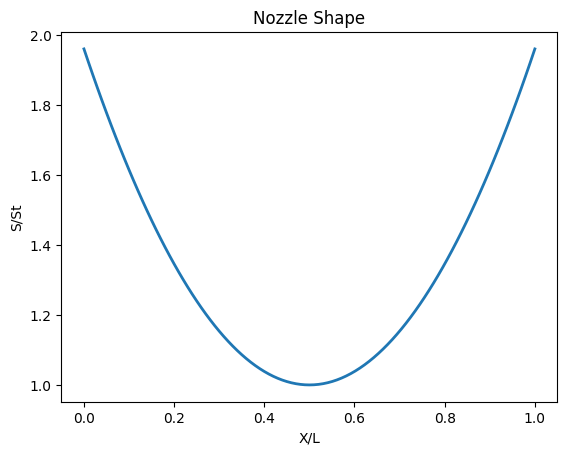

In [ ]:
geom = s_func(x)
fig, ax = plt.subplots()
ax.plot(x, geom, linewidth=2.0)
plt.xlabel("X/L")
plt.ylabel("S/St")
plt.title("Nozzle Shape")
#plt.ylim([0, 10])

**Architecture of my network**

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self , Layers , activator = nn.Tanh()):

        super(NeuralNet , self).__init__()

        # Main Neural Network
        # Input Layer
        self.model = nn.ModuleList( [nn.Linear(Layers[0],Layers[1])])

        # Other Layers
        for i in range(1,len(Layers)-1):
            self.model.append(activator)
            self.model.append(nn.Linear(Layers[i],Layers[i+1]))


        # Weight Initializer
        self.model.apply(self.init_weights)

        self.model = self.model.to(device)

    def forward(self , x):  # When Calling The Neural Net
        for layer in self.model:
            x = layer(x)
        return x

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight , gain = 5/3)

**Define function to generate vector Jacobian**

In [ ]:
def jacv_gen(x , direc):
    jacv = torch.zeros(x.shape , device = device)
    jacv[:,direc] = 1

    return jacv

**Steady State Euler Equation**

In [ ]:
from torch.autograd.functional import jvp

def Euler_Equation_1D(model , xcolloc, rho_0, C_0, L, gama, s_func, A_t, epsilon_2):

    global landa, pointwise_Residual

    rho_u_e = model(xcolloc)
    rho = rho_u_e[:,0]
    u = rho_u_e[:,1]
    e = rho_u_e[:,2]
    p = rho * e
    T = T_0 - (u * C_0)**2/(2*Cp)

    s = s_func(xcolloc)[:,0]
    ds_dx = jvp(s_func, xcolloc, v = jacv_gen(xcolloc , 0) , create_graph=True )[1]
    ds_dx = ds_dx[:,0]

    continuity_flux = lambda x: (model(x)[:,0]) * s_func(x)[:,0] * (model(x)[:,1])
    momentum_flux = lambda x: (model(x)[:,0]) * s_func(x)[:,0] * ((model(x)[:,1])**2) + ((model(x)[:,2]) * (model(x)[:,0]) * s_func(x)[:,0]) / gama
    energy_flux = lambda x: (((model(x)[:,0]) * (model(x)[:,2])) / (gama - 1) + (gama * (model(x)[:,0]) * (model(x)[:,1])**2) / 4) * s_func(x)[:,0] * (model(x)[:,1]) + \
                  (model(x)[:,0]) * (model(x)[:,2]) * s_func(x)[:,0] * (model(x)[:,1])
    G_U = lambda x: (continuity_flux(x), momentum_flux(x), energy_flux(x))
    dG_U_dx = jvp(G_U, xcolloc, v = jacv_gen(xcolloc , 0) , create_graph=True )[1]

    entropy_flux = lambda x: -(model(x)[:,0] * model(x)[:,1] * torch.log((model(x)[:,0] * model(x)[:,2]) / ((model(x)[:,0]) ** gama))) / (gama - 1)
    entropy_flux_dx = jvp(entropy_flux, xcolloc, v = jacv_gen(xcolloc , 0) , create_graph=True )[1]

    epsilon = 1e-5

    return torch.nn.MSELoss(epsilon,entropy_flux_dx) + torch.nn.MSELoss(dG_U_dx,(0, 0 ,0))

**Collocation Points
0<x<1**

In [ ]:
import itertools
x_array = np.array(list(x))
X_colloc = torch.tensor(x_array,dtype=torch.float32).to(device)
ds_dx = jvp(s_func, X_colloc, v = jacv_gen(X_colloc , 0) , create_graph=True )[1]

**Preparing training data and converting to Torch tensor**

In [ ]:
X_train = X_colloc

P_train = [[0.93], [0.8]]
mass_flow_rate = [[0.579], [0.579]]
rho_inlet = [[0.95]]
e_train = [[0.98]]

P_train = torch.tensor(P_train,dtype=torch.float32).to(device)
mass_flow_rate = torch.tensor(mass_flow_rate,dtype=torch.float32).to(device)
rho_inlet = torch.tensor(rho_inlet,dtype=torch.float32).to(device)
e_train = torch.tensor(e_train,dtype=torch.float32).to(device)

**Configuring PINN and its Optimizers**

In [ ]:
Layers = [1] + 4*[10] + [3] #input:x   output:rho,u,e

PINet = NeuralNet(Layers)

optimizer1 = torch.optim.Adam(PINet.parameters() , lr = 1e-3)
optimizer2 = torch.optim.LBFGS(PINet.parameters() , lr = 1e-1)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1 ,\
                                                        mode = 'min' ,\
                                                        patience = 120, \
                                                        factor = 0.8, \
                                                        threshold = 1e-5,\
                                                        verbose = True)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2 ,\
                                                        mode = 'min' ,\
                                                        patience = 10, \
                                                        factor = 0.1, \
                                                        verbose = True)

**Loss Function**

In [ ]:
loss_fn = torch.nn.MSELoss()
loss_fn_2 = torch.nn.MSELoss(reduction = 'sum')
loss_L1 = torch.nn.L1Loss(reduction = 'sum')

**Closure Definition**

In [ ]:
import math
def closure():
  optimizer.zero_grad()

  y_pred = PINet(X_train)
  temperature = T_0 - (y_pred[:,1] * C_0)**2/(2*Cp)
  p_pred = y_pred[:,0] * y_pred[:,2]

  IB_Loss = epsilon_1 * loss_fn((y_pred[-1,0] * y_pred[-1,2]) , P_train[1,0]) + \
            epsilon_1 * loss_fn(y_pred[0,0], rho_inlet[0,0]) + \
            epsilon_1 * loss_fn(y_pred[0,2], e_train[0,0]) + \
            epsilon_1 * loss_fn(y_pred[0,0] * y_pred[0,1] * s_func(X_train[0,0]), mass_flow_rate[0,0]) + \
            epsilon_1 * loss_fn(y_pred[-1,0]*y_pred[-1,1]*s_func(X_train[-1,0]), mass_flow_rate[1,0])
  PDE_Loss = Euler_Equation_1D(PINet , X_colloc[1:-1], rho_0, C_0, L, gama, s_func, A_t, epsilon_2)

  total_Loss = IB_Loss + PDE_Loss

  global val_total_Loss, val_IB_Loss, val_PDE_Loss
  val_total_Loss = total_Loss.item()
  val_IB_Loss = IB_Loss.item()
  val_PDE_Loss = PDE_Loss.item()
  total_Loss.backward()
  return total_Loss

**Main Loop**

In [ ]:
import time
import matplotlib.pyplot as plt

No_epoch = np.array([Adam_it , LBFGS_it]) # Closure (Adams) , L-BFGS

start = time.time()
total_Loss_values = []
IB_Loss_values = []
PDE_Loss_values = []
epoch_values = []

for epoch in range(No_epoch.sum()):

  if epoch < No_epoch[0]:
    optimizer = optimizer1
    scheduler = scheduler1
  else:
    optimizer = optimizer2
    scheduler = scheduler2

  optimizer.step(closure)
  scheduler.step(val_total_Loss)
  total_Loss_values.append(val_total_Loss)
  IB_Loss_values.append(val_IB_Loss)
  PDE_Loss_values.append(val_PDE_Loss)
  epoch_values.append(epoch)
  if(epoch%100 == 0):
    elapsed = time.time() - start
    print("Epoch: ", epoch,"total_Loss: ", val_total_Loss, "IB_Loss: ", val_IB_Loss, "PDE_Loss: ", val_PDE_Loss, "Time = ", elapsed)
  if(epoch == (No_epoch.sum()-1)):
    print("Epoch: ", epoch,"Loss: ", val_total_Loss, "Time = ", elapsed)

RuntimeError: ignored

## **Results**

**Loss chart**

In [ ]:
import matplotlib.pyplot as plt

y_pred = PINet(X_colloc)
e_pred = (y_pred[:,2]).detach().numpy()
U_pred = (y_pred[:,1]).detach().numpy()
rho_pred = (y_pred[:,0]).detach().numpy()

fig, ax = plt.subplots()
ax.plot(epoch_values, total_Loss_values, linewidth=2.0)
ax.plot(epoch_values, IB_Loss_values, linewidth=2.0)
ax.plot(epoch_values, PDE_Loss_values, linewidth=2.0)
plt.legend(["total_loss","IB_loss", "PDE_loss"], loc ="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
ax.set_yscale('log')
plt.ylim([1e-5, 1])

In [ ]:
fig, axs = plt.subplots(2)

# axs[0].plot(x[1:-1], pointwise_Residual_values[4], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[3], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[2], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[1], linewidth=2.0)
axs[0].plot(x[1:-1], pointwise_Residual_values[0], linewidth=2.0)
axs[0].legend(["it=10000", "it=8000","it=6000","it=4000", "it=2000"], loc ="lower left")
axs[0].set(xlabel='x', ylabel='Residual')
plt.ylim([-0.1, 0.1])

axs[1].plot(x[1:-1], pointwise_Residual_values[3], linewidth=2.0)
axs[1].legend(["it=10000"], loc ="lower left")
axs[1].set(xlabel='x', ylabel='Residual')

plt.ylim([-0.4, 0.4])

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('landa')

axs[0].plot(x[1:-1], landa_Values[9], linewidth=2.0)
axs[0].plot(x[1:-1], landa_Values[8], linewidth=2.0)
axs[0].plot(x[1:-1], landa_Values[7], linewidth=2.0)
axs[0].plot(x[1:-1], landa_Values[6], linewidth=2.0)
axs[0].plot(x[1:-1], landa_Values[5], linewidth=2.0)
axs[0].legend(["it=10000", "it=8000","it=6000","it=4000", "it=2000"], loc ="lower left")
axs[0].set(xlabel='x', ylabel='landa')

axs[1].plot(x[1:-1], landa_Values[9], linewidth=2.0)
axs[1].legend(["it=10000"], loc ="lower left")
axs[1].set(xlabel='x', ylabel='landa')

# plt.ylim([0, 1.2])

**PINN Results**

(0.0, 1.0)

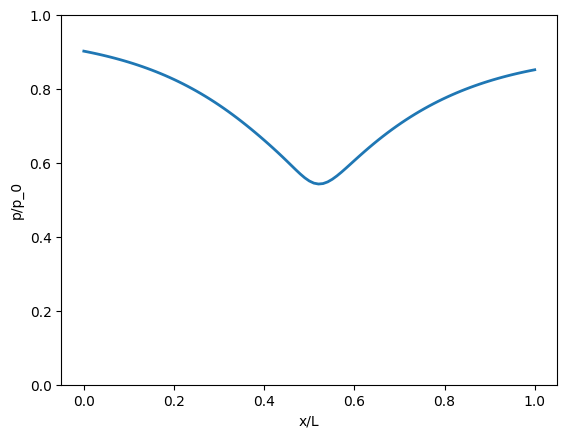

In [ ]:
fig, p = plt.subplots()
P_pred = rho_pred * e_pred
# for i in range (shock_index+1):
#   P_pred_static =  (P_pred * P_0) / P_0
# for i in range (shock_index+1,n_x):
#   P_pred_static =  (P_pred * P_0) / 877000
p.plot(x, P_pred, linewidth=2.0)
#print(P_pred)
plt.xlabel("x/L")
plt.ylabel("p/p_0")
plt.ylim([0,1])

(0.0, 1.1)

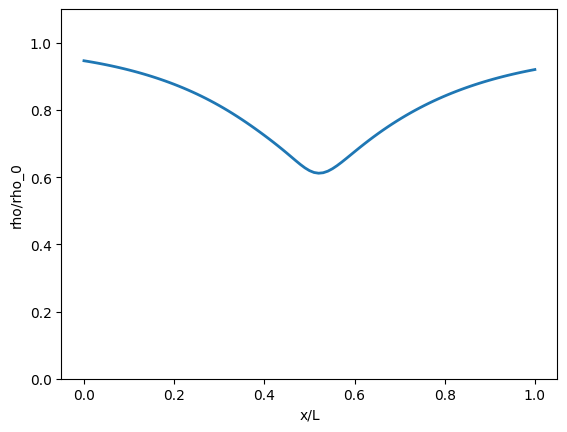

In [ ]:
fig, rho = plt.subplots()
rho.plot(x, rho_pred, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("rho/rho_0")
plt.ylim([0,1.1])

(0.0, 1.0)

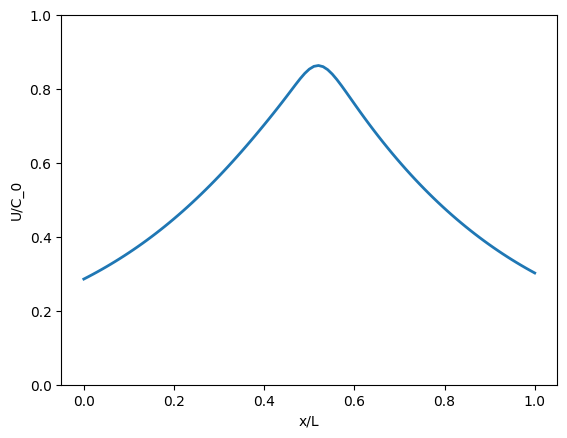

In [ ]:
fig, u = plt.subplots()
u.plot(x, U_pred, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("U/C_0")
plt.ylim([0,1])

(0.0, 1.0)

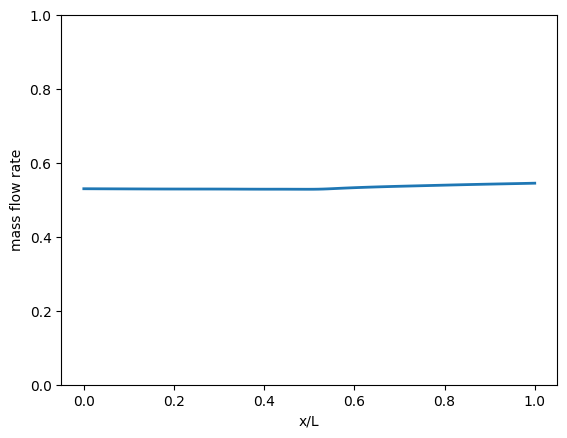

In [ ]:
fig, Mass = plt.subplots()
area = (s_func(X_colloc)[:,0]).detach().numpy()
mass_flow_rate = rho_pred * U_pred * area
# print(mass_flow_rate)
Mass.plot(x, mass_flow_rate, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("mass flow rate")
plt.ylim([0,1])

(0.0, 1.0)

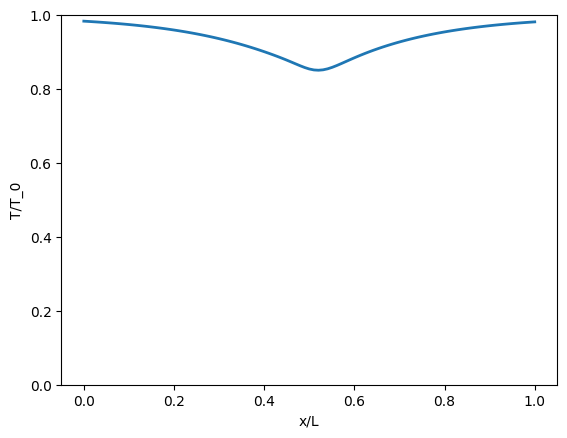

In [ ]:
fig, temp = plt.subplots()
temperature = T_0 - (U_pred * C_0)**2/(2*Cp)
T_pred = temperature/T_0
temp.plot(x, T_pred, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("T/T_0")
plt.ylim([0,1])
# print(T_pred)

(0.0, 1.0)

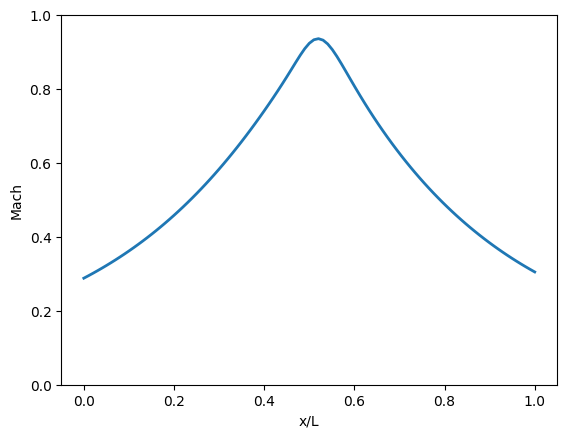

In [ ]:
fig, Mach = plt.subplots()
Mach_pred = U_pred * C_0 /(R * gama * temperature)**0.5
Mach.plot(x, Mach_pred, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Mach")
plt.ylim([0,1])
# print(Mach_pred)

(-0.05, 1.0)

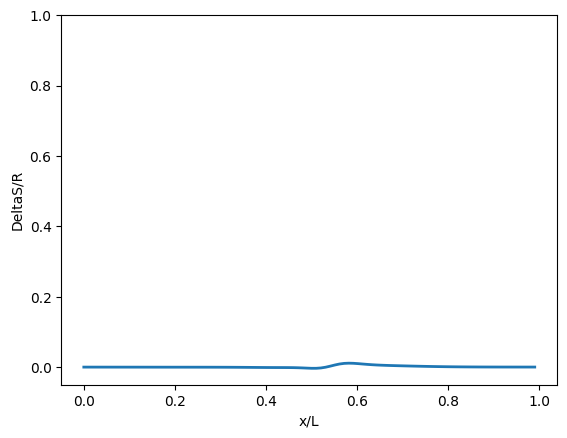

In [ ]:
import math

deltaS2_R_pred =  np.empty((n_x-1))
deltaS_R_pred =  np.empty((n_x-1))
P_pred_static = np.empty((n_x))

# for i in range(shock_index+1):
#   P_pred_static[i] = P_pred[i] * P_0
# for i in range(shock_index+1,n_x):
#   P_pred_static[i] = P_pred[i] * 877000

for i in range(n_x-1):
  deltaS2_R_pred[i] =  (Cp/R) * math.log(T_pred[i]) - math.log((P_pred_static[i] / P_0))
  deltaS_R_pred[i] =  (Cp/R) * math.log(T_pred[i+1]/T_pred[i]) - math.log((P_pred[i+1] / P_pred[i]))
  # deltaS_R_pred[i] =  (Cp/R) * math.log(T_pred[i+1]/T_pred[i]) - math.log((P_pred_static[i+1] / P_pred_static[i]))

fig, Mach = plt.subplots()
Mach.plot(x[0:-1], deltaS_R_pred, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("DeltaS/R")
plt.ylim([-0.05,1])

## **Analytical Solution**

### Supersonic without shock


In [ ]:
from sympy import symbols, solve

# x_C = np.array([np.linspace(0,0.5,n_x)]).T
# x_D = np.array([np.linspace(0.5,1,n_x)]).T
# geom_C = s_func(x_C)
# geom_D = s_func(x_D)
geom = s_func(x)

s_star = 0.00051 #m^2

# s_C_s_star = (geom_C * 0.00051) / s_star
# s_D_s_star = (geom_D * 0.00051) / s_star
s_s_star = (geom * A_t) / s_star

A = 2 / (gama + 1)
B = (gama - 1) / 2
n = (gama + 1) / (2 * (gama - 1))
M = symbols('M')

Mach_analytical_C = np.empty((n_x))
p_analytical_C = np.empty((n_x))
T_analytical_C = np.empty((n_x))
rho_analytical_C = np.empty((n_x))
deltaS_R =  np.empty((n_x - 1))

# Mach_analytical_D = np.empty((50))
# p_analytical_D = np.empty((n_x))
# T_analytical_D = np.empty((n_x))
# rho_analytical_D = np.empty((n_x))

for i in range(n_x):
  Eq1 = s_s_star[i,0] - (1/M) * (A * (1 + B * M**2))**n

  if i < n_C :
    Mach_analytical_C[i] = solve(Eq1)[0]
  else:
    Mach_analytical_C[i] = solve(Eq1)[1]

for i in range(n_x):
  p_analytical_C[i] = (1 + B * Mach_analytical_C[i]**2)**(-gama/(gama - 1))
  T_analytical_C[i] = (1 + B * Mach_analytical_C[i]**2)**(-1)
  rho_analytical_C[i] = (1 + B * Mach_analytical_C[i]**2)**(-1/(gama - 1))

  # p_analytical_D[i] = (1 + B * Mach_analytical_D[i]**2)**(-gama/(gama - 1))
  # T_analytical_D[i] = (1 + B * Mach_analytical_D[i]**2)**(-1)
  # rho_analytical_D[i] = (1 + B * Mach_analytical_D[i]**2)**(-1/(gama - 1))

# for i in range(n_x):
#   Eq1 = s_D_s_star[i,0] - (1/M) * (A * (1 + B * M**2))**n
#   Mach_analytical_D[i] = solve(Eq1)[1]
# for i in range(n_x):
#   p_analytical_D[i] = (1 + B * Mach_analytical_D[i]**2)**(-gama/(gama - 1))
#   T_analytical_D[i] = (1 + B * Mach_analytical_D[i]**2)**(-1)
#   rho_analytical_D[i] = (1 + B * Mach_analytical_D[i]**2)**(-1/(gama - 1))



NameError: ignored

### **plot prediction and analytical result**

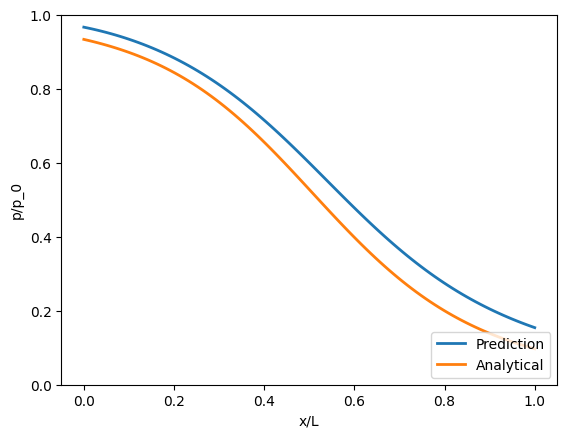

In [ ]:
fig, p = plt.subplots()
p.plot(x, P_pred , linewidth=2.0)
p.plot(x, p_analytical_C, linewidth=2.0)

plt.xlabel("x/L")
plt.ylabel("p/p_0")
plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="lower right")

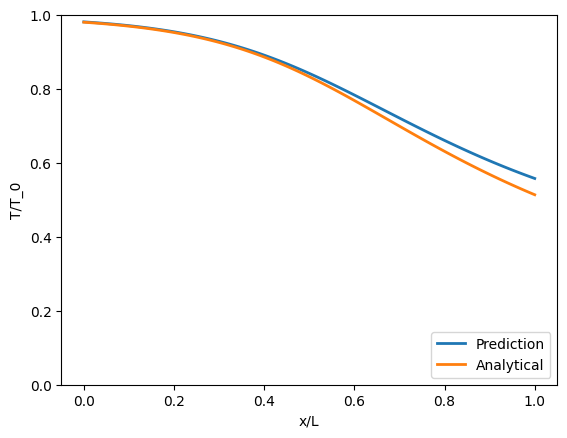

In [ ]:
fig, temp = plt.subplots()
temp.plot(x, T_pred, linewidth=2.0)
temp.plot(x, T_analytical_C, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("T/T_0")
plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="lower right")
# print(T_analytical)

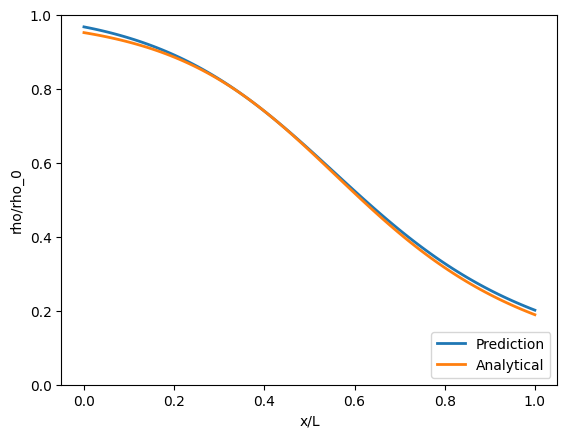

In [ ]:
fig, rho = plt.subplots()
rho.plot(x, rho_pred, linewidth=2.0)
rho.plot(x, rho_analytical_C, linewidth=2.0)

plt.xlabel("x/L")
plt.ylabel("rho/rho_0")
plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="lower right")
# print(rho_analytical)

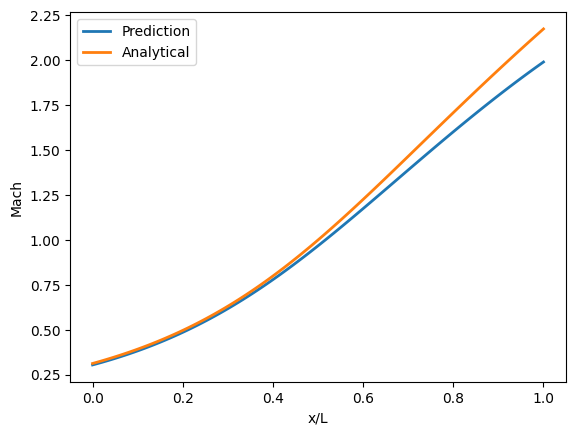

In [ ]:
fig, Mach = plt.subplots()
Mach.plot(x, Mach_pred, linewidth=2.0)
Mach.plot(x, Mach_analytical_C, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Mach")
# plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="upper left")
# print(Mach_analytical)
#print(x[50,0] * 0.00051)
#print(Mach_pred[50])

(-0.01, 0.01)

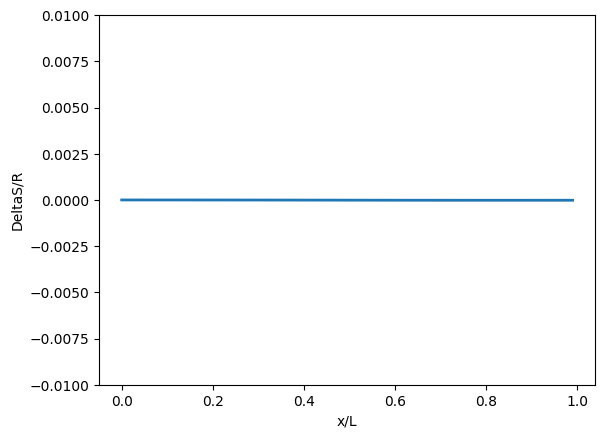

In [ ]:
import math
for i in range(n_x-1):
  deltaS_R[i] =  (Cp/R) * math.log(T_analytical_C[i+1] / T_analytical_C[i]) - math.log(p_analytical_C[i+1] / p_analytical_C[i])

fig, Mach = plt.subplots()
Mach.plot(x[0:-1], deltaS_R, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("DeltaS/R")
plt.ylim([-0.01,0.01])

### **Error calculation**

**Absolute error**

In [ ]:
Absolute_error_P = abs(P_pred - p_analytical_C)
Absolute_error_T = abs(T_pred - T_analytical_C)
Absolute_error_rho = abs(rho_pred - rho_analytical_C)
Absolute_error_Mach = abs(Mach_pred - Mach_analytical_C)
# print("Absolute_error_P = ", Absolute_error_P)
# print("Absolute_error_T = ", Absolute_error_T)
# print("Absolute_error_rho = ", Absolute_error_rho)
# print("Absolute_error_Mach = ", Absolute_error_Mach)

In [ ]:
fig, error_p = plt.subplots()
error_p.plot(x, Absolute_error_P, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_P")
# plt.ylim([0,0.2])

In [ ]:
fig, error_T = plt.subplots()
error_T.plot(x, Absolute_error_T, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_T")
plt.ylim([0,0.2])

In [ ]:
fig, error_rho = plt.subplots()
error_rho.plot(x, Absolute_error_rho, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_rho")
# plt.ylim([0,0.2])

In [ ]:
fig, error_Mach = plt.subplots()
error_Mach.plot(x, Absolute_error_Mach, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_Mach")
# plt.ylim([0,0.2])

In [ ]:
P_error_prediction = np.linalg.norm(P_pred - p_analytical, 2)/np.linalg.norm(p_analytical,2)
T_error_prediction = np.linalg.norm(T_pred - T_analytical, 2)/np.linalg.norm(p_analytical,2)
rho_error_prediction = np.linalg.norm(rho_pred - rho_analytical, 2)/np.linalg.norm(p_analytical,2)
Mach_error_prediction = np.linalg.norm(Mach_pred - Mach_analytical, 2)/np.linalg.norm(p_analytical,2)
print("Total_norm_P = ", P_error_prediction)
print("Total_norm_T = ", T_error_prediction)
print("Total_norm_rho = ", rho_error_prediction)
print("Total_norm_Mach = ", Mach_error_prediction)

In [ ]:
MSE_P = np.square(np.subtract(p_analytical, P_pred)).mean()
MSE_T = np.square(np.subtract(T_analytical, T_pred)).mean()
MSE_rho = np.square(np.subtract(rho_analytical, rho_pred)).mean()
MSE_Mach = np.square(np.subtract(Mach_analytical, Mach_pred)).mean()
print('MSE_P = ',MSE_P)
print('MSE_T = ',MSE_T)
print('MSE_rho = ',MSE_rho)
print('MSE_Mach = ',MSE_Mach)

### Supersonic

In [ ]:
from sympy import symbols, solve, nsolve, im


geom = s_func(x)
s_star1 = 0.00051 #m^2

Se_S_star1 = s_func(x)[n_x-1,0]
deltaS_R =  np.empty((n_x - 1))
total_deltaS_R =  np.empty(n_x-1)
total_P =  np.empty(n_x)

Pe_P01 = 0.8
P01 = 10**6 #pa

A = 2 / (gama + 1)
B = (gama - 1) / 2
n = (gama + 1) / (2 * (gama - 1))

C = Se_S_star1 * Pe_P01

Me = ((-1/(gama - 1)) + ((1/(gama - 1)**2) + (1/B) * (A**(2*n)) * ((1/C)**2))**0.5)**0.5

P02_Pe = (1 + B * (Me**2))**(gama / (gama - 1))
P02_P01 = P02_Pe * Pe_P01
P02 = P02_P01 * P01

# Define the symbols
M1 = symbols('M1')

# Define the equation
Eq1 = P02_P01 - (((1+gama)*M1**2)/(2+(gama-1)*M1**2))**(gama/(gama-1)) * ((gama+1)/(2*gama*M1**2-(gama-1)))**(1/(gama-1))

# Set the initial guess
x0 = 0

# Set the maximum distance from the initial guess to check
max_distance = 10

# Set the step size for increasing the distance
step_size = 0.1

# Find a numerical solution with nsolve for different initial guesses
sol = None
for distance in range(max_distance):
    x_guess = x0 + distance * step_size
    try:
        sol = nsolve(Eq1, M1, x_guess)
        if im(sol) == 0:  # Check if the imaginary part is zero
            break
    except:
        continue

# Print the solution
if sol is not None and im(sol) == 0:
    print("The Ma1 is:", sol)
else:
    print("Unable to find a real solution within the specified distance.")

S_shock_S_star1 = (1 / sol) * (A * (1 + B * sol**2))**n
M2 = ((sol**2 + 1/B) / ( (sol**2) * gama * (1 / B) - 1))**0.5
S_star2 = (Se_S_star1 * s_star1) / (C * P02_Pe)

print("shock_Location = ", S_shock_S_star1)
print("Ma2 = ", M2)
print("S_star2 = ", S_star2)

shock_index = find_index_within(geom, S_shock_S_star1, 0.01)
print(shock_index)

M = symbols('M')
Mach_analytical = np.zeros((n_x))
p_analytical = np.zeros((n_x))
T_analytical = np.zeros((n_x))
rho_analytical = np.zeros((n_x))
# print("Shock index = ", shock_index, "n_x =", n_x)
for i in range(n_x):
  Eq2 = geom[i,0] - (1/M) * (A * (1 + B * M**2))**n

  if i <= n_C :
    temp = solve(Eq2)
    Mach_analytical[i] = temp[0]
    # total_P[i] = P01
    # print("i<n_x/2->",i,"  Mach_analytical[i]->",temp,"\n")
  elif i> n_C and geom[i,0] < S_shock_S_star1:
    # print(geom[i,0])
    # print(i)
    # print(solve(Eq2))
    Mach_analytical[i] = solve(Eq2)[1]

    # print("i>= n_x/2 and geom[i,0] < S_shock_S_star1->", i,"  Mach_analytical[i]->",Mach_analytical[i],"\n")

    # total_P[i] = P01
  elif i == shock_index or i == (shock_index + 1):
    Mach_analytical[shock_index] = sol
    Mach_analytical[shock_index + 1] = M2
    # print("i == shock_index or i == (shock_index + 1)->", i,"  Mach_analytical[i]->",Mach_analytical[i], "  Mach_analytical[i + 1]->",Mach_analytical[i+1], "\n")
  else:
    Eq3 = (geom[i,0]*s_star1)/S_star2 - (1/M) * (A * (1 + B * M**2))**n
    Mach_analytical[i] = solve(Eq3)[0]
    # print("else->", i,"  Mach_analytical[i]->",Mach_analytical[i], "\n")
    # total_P[i] = P02

for i in range(shock_index + 1):
  p_analytical[i] = (1 + B * Mach_analytical[i]**2)**(-gama/(gama - 1))
  T_analytical[i] = (1 + B * Mach_analytical[i]**2)**(-1)
  rho_analytical[i] = (1 + B * Mach_analytical[i]**2)**(-1/(gama - 1))

Py_Px = (1 + (2 * gama) / (gama + 1) * (sol**2 - 1))
# print(Py_Px)
p_analytical[shock_index + 1] = Py_Px * (p_analytical[shock_index] ) * (1/P02_P01)
Ty_Tx = (1 + ((2 * gama) / (gama + 1)) * (sol**2 - 1)) * ((2 + (gama - 1) * sol**2) / ((gama + 1) * sol**2))
# print(Ty_Tx)
T_analytical[shock_index + 1] = Ty_Tx * (T_analytical[shock_index] )
Rhoy_Rhox = Py_Px / Ty_Tx
rho_analytical[shock_index + 1] = Rhoy_Rhox * (rho_analytical[shock_index] )

for i in range(shock_index + 2 , n_x):
  p_analytical[i] = (1 + B * Mach_analytical[i]**2)**(-gama/(gama - 1))
  T_analytical[i] = (1 + B * Mach_analytical[i]**2)**(-1)
  rho_analytical[i] = (1 + B * Mach_analytical[i]**2)**(-1/(gama - 1))

# for i in range(int(n_x/2)):
#   total_P[i] = ((((gama + 1)* Mach_analytical[i]**2) / (2 + (gama +1)*Mach_analytical[i]**2))**gama/(gama + 1)) *\
#    ((gama + 1) / (2*gama*Mach_analytical[i]**2 - (gama - 1)))**(1/(gama - 1))
  # print(i)
# print(p_analytical)
# print(total_P)

The Ma1 is: 1.64793108523938
shock_Location =  1.29041468045714
Ma2 =  0.654535667641709
S_star2 =  0.0005816569861349774
77


### **plot prediction and analytical result**

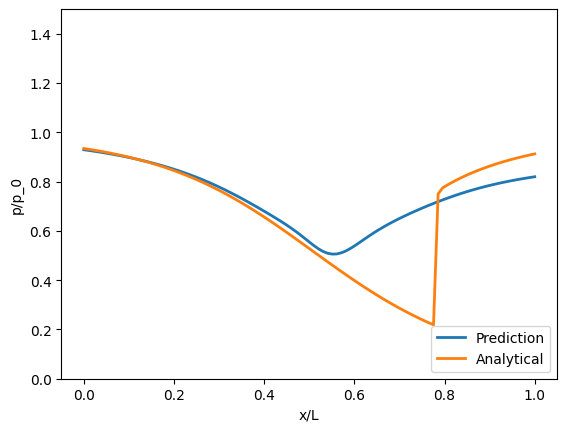

In [ ]:
fig, p = plt.subplots()
p.plot(x, P_pred , linewidth=2.0)
p.plot(x, p_analytical, linewidth=2.0)

plt.xlabel("x/L")
plt.ylabel("p/p_0")
plt.ylim([0,1.5])
plt.legend(["Prediction", "Analytical"], loc ="lower right")
# print(p_analytical)

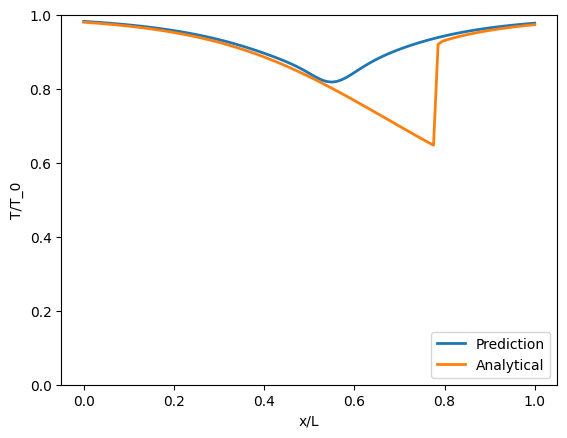

In [ ]:
fig, temp = plt.subplots()
temp.plot(x, T_pred, linewidth=2.0)
temp.plot(x, T_analytical, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("T/T_0")
plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="lower right")
# print(T_analytical)

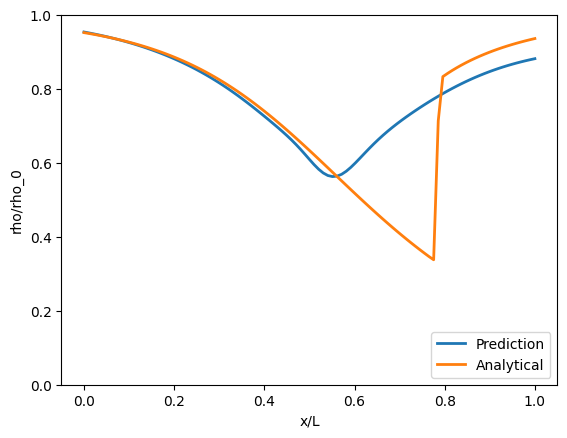

In [ ]:
fig, rho = plt.subplots()
rho.plot(x, rho_pred, linewidth=2.0)
rho.plot(x, rho_analytical, linewidth=2.0)

plt.xlabel("x/L")
plt.ylabel("rho/rho_0")
plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="lower right")
# print(rho_analytical)

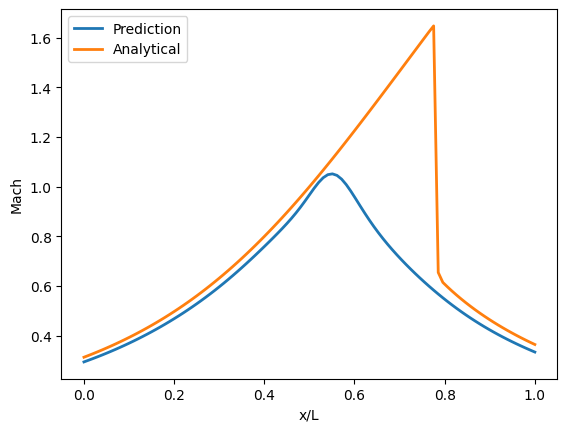

In [ ]:
fig, Mach = plt.subplots()
Mach.plot(x, Mach_pred, linewidth=2.0)
Mach.plot(x, Mach_analytical, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Mach")
# plt.ylim([0,1])
plt.legend(["Prediction", "Analytical"], loc ="upper left")
# print(Mach_analytical)
#print(x[50,0] * 0.00051)
#print(Mach_pred[50])

(-0.1, 1.0)

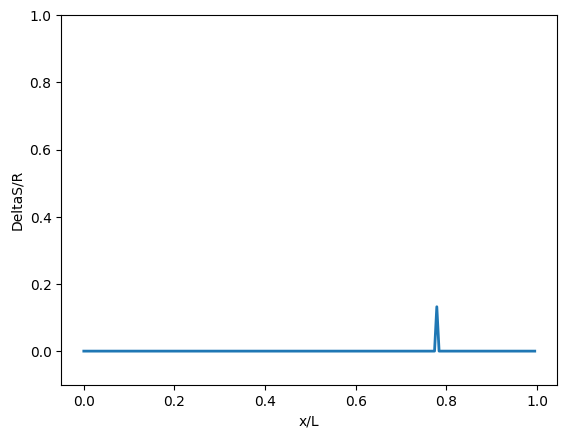

In [ ]:
import math
p_static = np.zeros((n_x))
T_static = np.zeros((n_x))
S2_R = np.zeros((n_x))

for i in range(shock_index+1):
  p_static[i] = (p_analytical[i] * P01)
for i in range(shock_index+1,n_x):
  p_static[i] = (p_analytical[i] * P02)
for i in range(n_x):
  T_static[i] = T_analytical[i] * T_0

for i in range(n_x-1):
  S2_R[i] =  (Cp/R) * math.log(T_static[i]/T_0) - math.log(p_static[i]/P01)
  deltaS_R[i] =  (Cp/R) * math.log(T_analytical[i+1]/T_analytical[i]) - math.log(p_static[i+1]/p_static[i])
  # total_deltaS_R[i] = - math.log(total_P[i+1] / total_P[i])

fig, Mach = plt.subplots()
# Mach.plot(x[0:-1], deltaS_R_pred, linewidth=2.0)
Mach.plot(x[0:-1], deltaS_R, linewidth=2.0)
# Mach.plot(x[0:-1], S2_R[0:-1], linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("DeltaS/R")
# plt.ylabel("S2/R")
plt.ylim([-0.1,1])
# print(deltaS_R)
# deltaS =  (Cp/R) * math.log(0.94791925 / 0.72281733) - math.log(0.82927714 / 0.32107017)
# print((Cp/R) * math.log(T_analytical[shock_index+1] / T_analytical[shock_index]))
# print(T_analytical[shock_index+2],T_analytical[shock_index+1])
# print(math.log(p_analytical[shock_index] / p_analytical[shock_index -1]))
# print(p_analytical[shock_index+2],p_analytical[shock_index+1])

### **Error calculation**

**Absolute error**

In [ ]:
Absolute_error_P = abs(P_pred - p_analytical)
Absolute_error_T = abs(T_pred - T_analytical)
Absolute_error_rho = abs(rho_pred - rho_analytical)
Absolute_error_Mach = abs(Mach_pred - Mach_analytical)
# print("Absolute_error_P = ", Absolute_error_P)
# print("Absolute_error_T = ", Absolute_error_T)
# print("Absolute_error_rho = ", Absolute_error_rho)
# print("Absolute_error_Mach = ", Absolute_error_Mach)

Text(0, 0.5, 'Absolute_error_P')

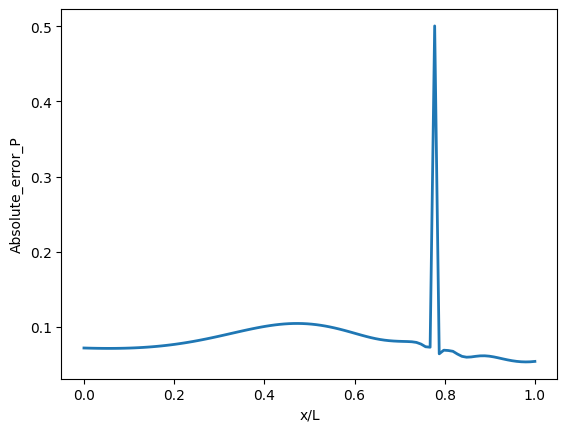

In [ ]:
fig, error_p = plt.subplots()
error_p.plot(x, Absolute_error_P, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_P")
# plt.ylim([0,0.2])

(0.0, 0.2)

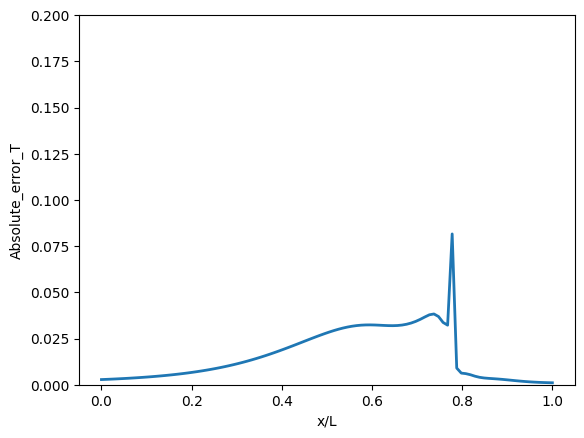

In [ ]:
fig, error_T = plt.subplots()
error_T.plot(x, Absolute_error_T, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_T")
plt.ylim([0,0.2])

Text(0, 0.5, 'Absolute_error_rho')

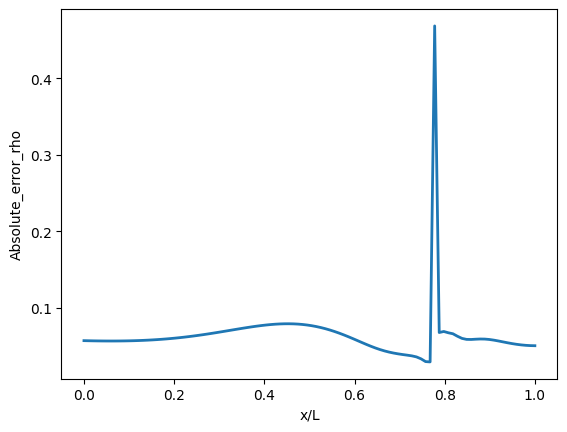

In [ ]:
fig, error_rho = plt.subplots()
error_rho.plot(x, Absolute_error_rho, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_rho")
# plt.ylim([0,0.2])

Text(0, 0.5, 'Absolute_error_Mach')

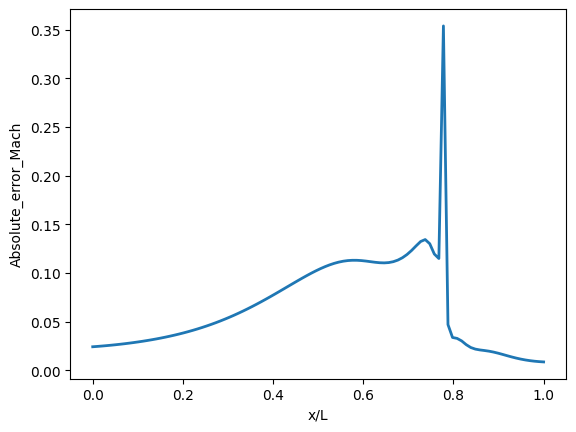

In [ ]:
fig, error_Mach = plt.subplots()
error_Mach.plot(x, Absolute_error_Mach, linewidth=2.0)
plt.xlabel("x/L")
plt.ylabel("Absolute_error_Mach")
# plt.ylim([0,0.2])

**Total norm**

In [ ]:
P_error_prediction = np.linalg.norm(P_pred - p_analytical, 2)/np.linalg.norm(p_analytical,2)
T_error_prediction = np.linalg.norm(T_pred - T_analytical, 2)/np.linalg.norm(p_analytical,2)
rho_error_prediction = np.linalg.norm(rho_pred - rho_analytical, 2)/np.linalg.norm(p_analytical,2)
Mach_error_prediction = np.linalg.norm(Mach_pred - Mach_analytical, 2)/np.linalg.norm(p_analytical,2)
print("Total_norm_P = ", P_error_prediction)
print("Total_norm_T = ", T_error_prediction)
print("Total_norm_rho = ", rho_error_prediction)
print("Total_norm_Mach = ", Mach_error_prediction)

Total_norm_P =  0.13020139291622762
Total_norm_T =  0.02910074743883905
Total_norm_rho =  0.10541767731068215
Total_norm_Mach =  0.11114123190869032


**Mean Squared Error**

In [ ]:
MSE_P = np.square(np.subtract(p_analytical, P_pred)).mean()
MSE_T = np.square(np.subtract(T_analytical, T_pred)).mean()
MSE_rho = np.square(np.subtract(rho_analytical, rho_pred)).mean()
MSE_Mach = np.square(np.subtract(Mach_analytical, Mach_pred)).mean()
print('MSE_P = ',MSE_P)
print('MSE_T = ',MSE_T)
print('MSE_rho = ',MSE_rho)
print('MSE_Mach = ',MSE_Mach)

MSE_P =  0.009037746216766715
MSE_T =  0.00045147859904878546
MSE_rho =  0.005924555433870894
MSE_Mach =  0.006585356547872325


**Test**

In [ ]:
from torch.autograd.functional import jvp
x = np.array([[1, 2, 3]]).T
#print(x[0])
x = torch.tensor(x, dtype=torch.float32).to(device)
F1 = lambda x: x**2
#print(F1(x))
dif_F1 = jvp(F1, x, v = jacv_gen(x , 0) , create_graph=True )[1]
#print(dif_F1)
F2 = lambda x: 3*x
#print(F2(x))
dif_F2 = jvp(F2, x, v = jacv_gen(x , 0) , create_graph=True )[1]
#print(dif_F2)
F3 = lambda x: torch.sin(torch.pi*x)
#print(F3(x))
dif_F3 = jvp(F3, x, v = jacv_gen(x , 0) , create_graph=True )[1]
#print(dif_F3)
flux = lambda x: (F1(x), F2(x), F3(x))
#print(flux(x))
dif_flux = jvp(flux, x, v = jacv_gen(x , 0) , create_graph=True )[1]
#print(dif_flux)
flux_2 = lambda x: (F1(x) * F2(x) * F3(x))
dif_flux_2 = jvp(flux_2, x, v = jacv_gen(x , 0) , create_graph=True )[1]
print(dif_flux_2)
true_dif_flux_2 = dif_F1 * F2(x) * F3(x) + F1(x) * dif_F2 * F3(x) + F1(x) * F2(x) * dif_F3
print(true_dif_flux_2)

tensor([[  -9.4248],
        [  75.3982],
        [-254.4690]], grad_fn=<AddBackward0>)
tensor([[  -9.4248],
        [  75.3982],
        [-254.4690]], grad_fn=<AddBackward0>)


In [ ]:
f = lambda x: [x**2, 3*x, np.sin(x)]
x = np.array([2,3,4])
inp = torch.tensor(list(x), dtype=torch.float32).to(device)
res = f(inp)
dif = jvp(f, inp, v = jacv_gen(inp , 0) , create_graph=True )[1]
print(res)

In [ ]:
s = lambda x: x**2 + 3 * x - 1
print(s(2))
dsdx = jvp(s, X_colloc, v = jacv_gen(X_colloc , 0) , create_graph=True)[1]
print(X_colloc, dsdx)